### SET PARAMETERS

In [1]:
from pathlib import Path

# DATA SETTINGS
TRAIN_PATH = Path('data/vids/split/train')
TEST_PATH = Path('data/vids/split/test')
IMG_SIZE = 256

# MESONET MODEL
# IF USING FrameGenerator
FRAMES_PER_VIDEO_MESO = 100

# IF USING SamplingFrameGenerator
SAMPLES_PER_VIDEO_MESO = 10
FRAMES_PER_SAMPLE_MESO = 10

# MOUTHNET MODEL
# IF USING FrameGenerator
FRAMES_PER_VIDEO_MOUTH = 20

# IF USING SamplingFrameGenerator
SAMPLES_PER_VIDEO_MOUTH = 2
FRAMES_PER_SAMPLE_MOUTH = 10

# BOTH
# TRAINING SETTINGS
EPOCHS_MESO = 10
EPOCHS_MOUTH = 10
BATCH_SIZE = 10

### LOAD MESONET DATA (Sampling Frame Generator)

In [2]:
import tensorflow as tf
from src.datagen import SamplingFrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = SamplingFrameGenerator(TRAIN_PATH, SAMPLES_PER_VIDEO_MESO, FRAMES_PER_SAMPLE_MESO, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = SamplingFrameGenerator(TEST_PATH, SAMPLES_PER_VIDEO_MESO, FRAMES_PER_SAMPLE_MESO, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (100, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (100, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE/TRAIN (Mesonet Model - Sampling Frame Generator)

In [3]:
from src.models import get_mesonet_model
from src.helpers import save_history
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# LOAD NEW MODEL
model = get_mesonet_model()

# VERIFY MODEL
model.summary()

MODEL_NAME = "MESONET_SampleFrame"

# TRAIN MODEL

# INITIALIZE OPTIMIZER
optimizer = Adam()

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MESO,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10
    219/Unknown 847s 4s/step - accuracy: 0.5436 - loss: 0.7688

c:\CS5100\deepfake-detection\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1070s 5s/step - accuracy: 0.5437 - loss: 0.7685 - val_accuracy: 0.5015 - val_loss: 0.6791
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 28893s 133s/step - accuracy: 0.7219 - loss: 0.6080 - val_accuracy: 0.6925 - val_loss: 0.6143
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 658s 3s/step - accuracy: 0.7723 - loss: 0.5097 - val_accuracy: 0.7692 - val_loss: 0.4955
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.8390 - loss: 0.3988 - val_accuracy: 0.7862 - val_loss: 0.4635
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.8317 - loss: 0.4192 - val_accuracy: 0.7897 - val_loss: 0.4821
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 615s 3s/step - accuracy: 0.7725 - loss: 0.4596 - val_accuracy: 0.8568 - val_loss: 0.3672
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 614s 3s/step - accuracy: 0.8543 - loss: 0.3489 - val_accuracy: 0.8360 - val_loss: 0.3716
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.8794 - loss: 0.2850 - val_accuracy: 

### VISUALIZE TRAINING HISTORY

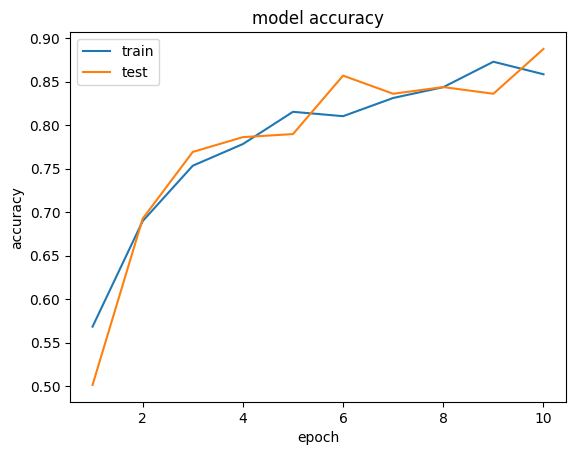

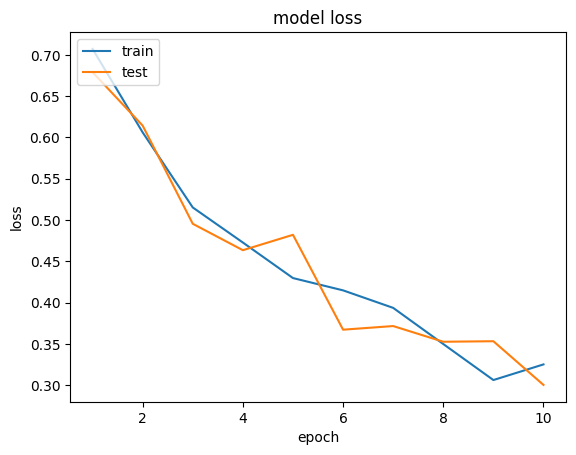

In [4]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS_MESO + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS_MESO + 1, 1),history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS_MESO + 1),history.history['loss'])
plt.plot(range(1, EPOCHS_MESO + 1),history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### LOAD MOUTHNET DATA (Sampling Frame Generator)

In [2]:
import tensorflow as tf
from src.datagen import SamplingFrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = SamplingFrameGenerator(TRAIN_PATH, SAMPLES_PER_VIDEO_MOUTH, FRAMES_PER_SAMPLE_MOUTH, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = SamplingFrameGenerator(TEST_PATH, SAMPLES_PER_VIDEO_MOUTH, FRAMES_PER_SAMPLE_MOUTH, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (20, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (20, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE/TRAIN/PLOT (Mouthnet Model - Sampling Frame Generator)

In [3]:
from src.models import get_mouthnet_model
from src.helpers import save_history
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# LOAD NEW MODEL
model = get_mouthnet_model()

# VERIFY MODEL
model.summary()

MODEL_NAME = "MOUTHNET_SampleFrame"

# INITIALIZE OPTIMIZER
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9, weight_decay=lr / EPOCHS_MOUTH)

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MOUTH,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 6, 6, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,078,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,414,881 (234.28 MB)

 Trainable params: 61,354,337 (234.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

Epoch 1/10
    219/Unknown 1098s 5s/step - accuracy: 0.4866 - loss: 0.8332

c:\CS5100\deepfake-detection\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1188s 5s/step - accuracy: 0.4867 - loss: 0.8331 - val_accuracy: 0.5000 - val_loss: 0.8405
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1202s 5s/step - accuracy: 0.4667 - loss: 0.7889 - val_accuracy: 0.5000 - val_loss: 0.6854
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1377s 6s/step - accuracy: 0.4915 - loss: 0.8627 - val_accuracy: 0.5000 - val_loss: 0.6818
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1374s 6s/step - accuracy: 0.4577 - loss: 0.7557 - val_accuracy: 0.5000 - val_loss: 0.6844
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1371s 6s/step - accuracy: 0.4774 - loss: 0.7911 - val_accuracy: 0.5000 - val_loss: 0.6848
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1368s 6s/step - accuracy: 0.4642 - loss: 0.8806 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1369s 6s/step - accuracy: 0.4966 - loss: 0.7717 - val_accuracy: 0.5000 - val_loss: 0.7728
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1352s 6s/step - accuracy: 0.5144 - loss: 0.8473 - val_accurac

### VISUALIZE TRAINING HISTORY

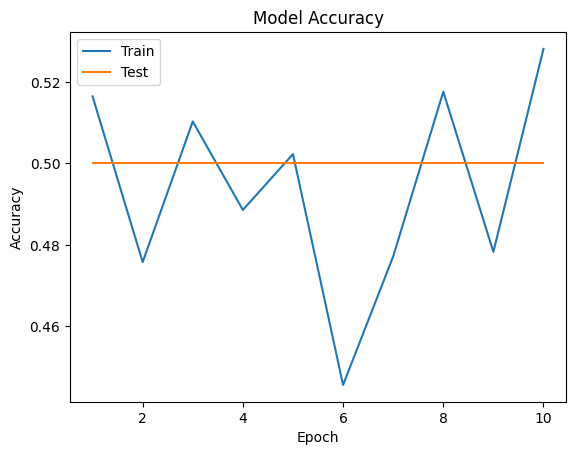

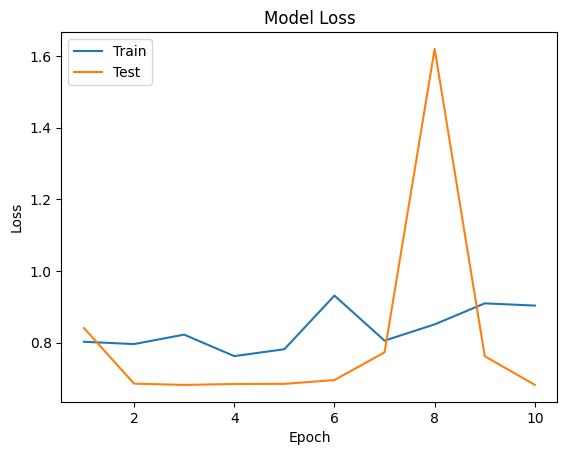

In [4]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS_MOUTH + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS_MOUTH + 1, 1),history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS_MOUTH + 1),history.history['loss'])
plt.plot(range(1, EPOCHS_MOUTH + 1),history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### LOAD DATA MESONET (Regular Frame Generator)

In [2]:
import tensorflow as tf
from src.datagen import FrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = FrameGenerator(TRAIN_PATH, FRAMES_PER_VIDEO_MESO, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO_MESO, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (100, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (100, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE/TRAIN/PLOT (Mesonet Model - Regular Frame Generator)

In [3]:
from src.models import get_mesonet_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from time import perf_counter
from src.helpers import save_history

# LOAD NEW MODEL
model = get_mesonet_model()

# VERIFY MODEL
model.summary()

MODEL_NAME = "MESONET_RegularFrame"

# TRAIN MODEL

# INITIALIZE OPTIMIZER
optimizer = Adam()

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MESO,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10
    219/Unknown 479s 2s/step - accuracy: 0.5514 - loss: 0.7325

c:\CS5100\deepfake-detection\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.5517 - loss: 0.7322 - val_accuracy: 0.5000 - val_loss: 0.6720
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.7563 - loss: 0.5353 - val_accuracy: 0.6712 - val_loss: 0.5821
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.7821 - loss: 0.4802 - val_accuracy: 0.7130 - val_loss: 0.5757
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.7794 - loss: 0.4751 - val_accuracy: 0.8413 - val_loss: 0.4402
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.8005 - loss: 0.4260 - val_accuracy: 0.7812 - val_loss: 0.4616
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.8445 - loss: 0.3692 - val_accuracy: 0.8293 - val_loss: 0.3875
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.8653 - loss: 0.3500 - val_accuracy: 0.8068 - val_loss: 0.3958
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.8579 - loss: 0.3591 - val_accuracy: 0.842

### VISUALIZE TRAINING HISTORY

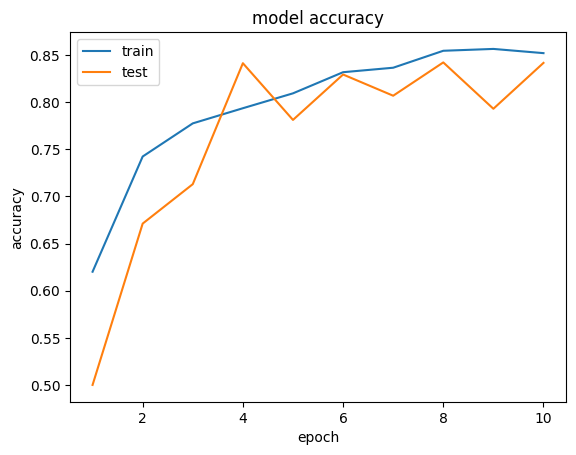

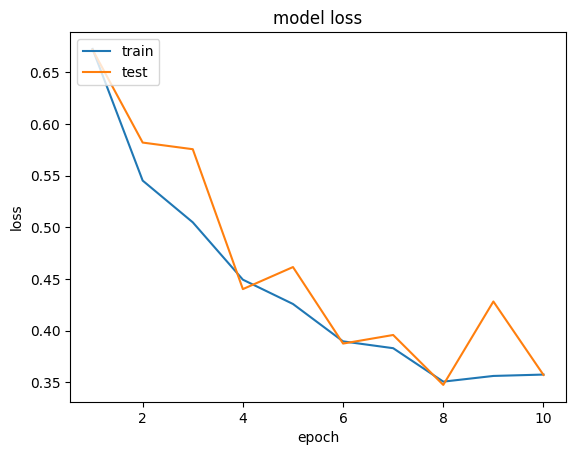

In [4]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS_MESO + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS_MESO + 1, 1),history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS_MESO + 1),history.history['loss'])
plt.plot(range(1, EPOCHS_MESO + 1),history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### LOAD DATA MOUTHNET (Regular Frame Generator)

In [5]:
import tensorflow as tf
from src.datagen import FrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = FrameGenerator(TRAIN_PATH, FRAMES_PER_VIDEO_MOUTH, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO_MOUTH, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (20, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (20, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE/TRAIN/PLOT (Mouthnet Model - Regular Frame Generator)

In [6]:
from src.models import get_mouthnet_model
from src.helpers import save_history
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# LOAD NEW MODEL
model = get_mouthnet_model()

# VERIFY MODEL
model.summary()

MODEL_NAME = "MOUTHNET_RegularFrame_10Epochs"

# INITIALIZE OPTIMIZER
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9, weight_decay=lr / EPOCHS_MOUTH)

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MOUTH,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 6, 6, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,078,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,414,881 (234.28 MB)

 Trainable params: 61,354,337 (234.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1201s 5s/step - accuracy: 0.5219 - loss: 0.8344 - val_accuracy: 0.5000 - val_loss: 0.9224
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1221s 6s/step - accuracy: 0.5009 - loss: 0.8798 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1432s 7s/step - accuracy: 0.4866 - loss: 0.8078 - val_accuracy: 0.5000 - val_loss: 0.6823
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1441s 7s/step - accuracy: 0.5233 - loss: 0.8437 - val_accuracy: 0.5000 - val_loss: 0.8316
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1434s 7s/step - accuracy: 0.5585 - loss: 0.7987 - val_accuracy: 0.5000 - val_loss: 0.8307
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1432s 7s/step - accuracy: 0.5404 - loss: 0.8149 - val_accuracy: 0.5000 - val_loss: 0.7210
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1440s 7s/step - accuracy: 0.5682 - loss: 0.7784 - val_accuracy: 0.5000 - val_loss: 1.0178
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1438s 7s/step - accuracy: 0.5173 - loss: 0.8441 - 

### VISUALIZE TRAINING HISTORY

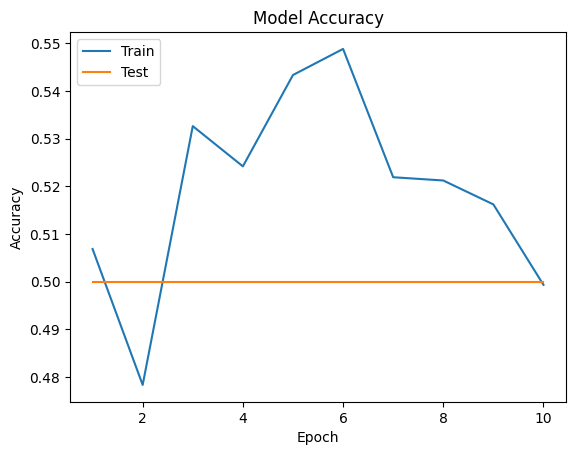

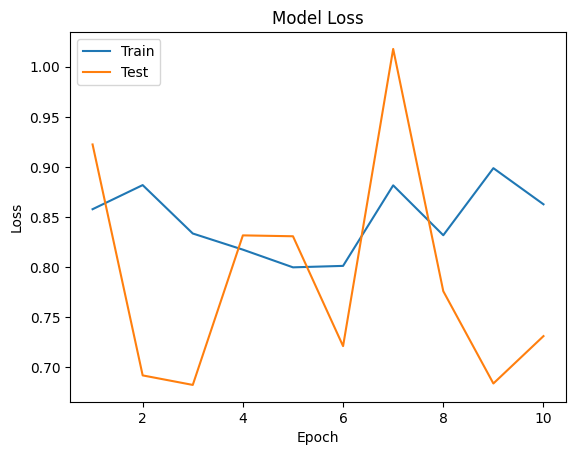

In [7]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS_MOUTH + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS_MOUTH + 1, 1),history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS_MOUTH + 1),history.history['loss'])
plt.plot(range(1, EPOCHS_MOUTH + 1),history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()